In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset ,DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
from sklearn import datasets as dt
import seaborn as sns
from sklearn.datasets import make_moons

# Alt Dataset


/users/kent/stadiset/anaconda3/envs/cnn/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


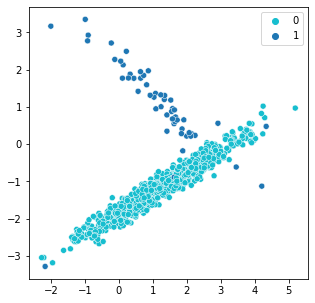

In [20]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')

fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(5,5))
plt_ind_list = np.arange(3)+131

for class_sep,plt_ind in zip([1],plt_ind_list):
    X,y = dt.make_classification(
    n_samples=1000, 
    n_features=2, 
    n_redundant=0,
    n_clusters_per_class=1,
    weights=[0.95],
    flip_y=0.01, #add noise
    class_sep =1.2,
    random_state=42
)
    palette = {0:"tab:cyan",
               1:"tab:blue", 
               }
    sns.scatterplot(X[:,0],X[:,1], hue = y, palette=palette )

plt.show()

# Data Preparation

In [ ]:
data = pd.read_csv("/users/kent/stadiset/Research Work/ReLU/score.csv")
data.head()

In [ ]:
sns.scatterplot(data['A'],data['B'], hue = data['class'])

In [ ]:
X = data.iloc[:,:-1].values
print(X)

In [ ]:
y = data.iloc[:,-1].values 
print(y)

In [21]:
#seperate the data 
ss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.4, random_state = 31)

for train_index, test_index in ss.split(X,y):
    print("n_split","TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

n_split TRAIN: [  3 309 166 369 754 279 872 256 333 467 446 229 789 717 377 200 529 431
 580 843 840 546 955 234 429 919 247 743 352 793 368  18 450 509 732 655
 462 854 180 108 833 783 595 249 983 707 448 545 797 970 210 636 596 671
 746 220  37 516 126 435 896 773  22 290 856 144 650 485 293 869 897  93
 835  76 109 632 986 473 586 861  41  61  80 214 658 787 786 472 667  35
 871 115 399 765 589 957 866 421 283 437 292 142 513 190 884 443 453 143
 356 611 394 799 996 105 734 918 102 691 527 908 924 119 963 999 336 617
 777 776 408  23 209 705 774  87 179 146 113 795 805 500 938 972 935 609
 982 337 635 741 407  20 206 470 916 588 718 521 159 268 461 848 330 846
 125  52 602  89 561 193 903 722 578  54 239 570 600 597 444 618 192 493
 168 469 133 150 567 138 246  11 296 120  84 255 802 403 877 801 111 762
 904 223 716 396 946 823 951 757 837 643 890 359 334 401 301 100 923 964
 969 847 331 285 878 874 364 388 985 392 490 831  56 587 844  58 505 668
  91 468 430 156 868 232 124 213 314

In [22]:
#standardize features of the featuers (x-values)
sc = StandardScaler()
xtrain = sc.fit_transform(X_train)
xtest = sc.transform(X_test)
print(xtrain)
#convert to tensors
xtrain,xtest = map(torch.tensor, (X_train,X_test))

#make tensors dtype as float for x values for training purposes
xtrain = xtrain.float()
xtest = xtest.float()

[[ 1.84752936  1.23297467]
 [ 0.77485639  0.37240573]
 [-1.1590748  -1.12347088]
 ...
 [-1.61504376 -1.69156491]
 [-0.36577145 -0.59388841]
 [ 0.59366937 -0.1651907 ]]


In [23]:
class dds(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

In [24]:
mydata = dds(xtrain,y_train)


train_loader = DataLoader(mydata, batch_size = 5)

train_features, train_labels = next(iter(train_loader))
print(train_features)

tensor([[ 3.3031,  0.0335],
        [ 2.0883, -0.7289],
        [-0.1020, -2.0542],
        [ 1.7665, -1.0648],
        [-0.0994, -1.8599]])


# Define Network

In [25]:
#create NN 

class FeedForward(torch.nn.Module):
    def __init__(self, n_inputs, n_outputs, hidden_size):
        super(FeedForward,self).__init__()
        self.inputs = n_inputs
        self.outputs = n_outputs
        self.hidden = hidden_size
        
        #define 2D NN layers 
        self.fc1 = torch.nn.Linear(self.inputs, self.hidden, bias =True)
        self.fc2 = torch.nn.Linear(self.hidden, self.hidden, bias =True)
        self.fc3 = torch.nn.Linear(self.hidden, self.outputs, bias =True)
        
        #define activation function 
        self.relu = torch.nn.ReLU()
        
#         self.init_weights()
        self.out_act = torch.nn.Sigmoid()
#     def init_weights(self):
#         torch.nn.init.kaiming_normal_(self.fc1.weight)
#         torch.nn.init.kaiming_normal_(self.fc2.weight)
#         torch.nn.init.kaiming_normal_(self.fc3.weight)

    def forward(self, features):
        output1 = self.fc1(features)
        output1_relu = self.relu(output1)
        
        output2 = self.fc2(output1_relu)
        output2_relu = self.relu(output2)
        
        output3 = self.fc3(output2_relu)
        output = self.out_act(output3)
    
        return output

In [33]:
print(xtrain.shape[1]) #2
#create network object 
model = FeedForward(n_inputs = xtrain.shape[1], n_outputs =1, hidden_size = 2)
#create loss 
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()

#create optimization or gradient 
# optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.001,  momentum = 0.9)
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)
print(model)

2
FeedForward(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=1, bias=True)
  (relu): ReLU()
  (out_act): Sigmoid()
)


# Train

In [ ]:
#train the network 

epochs = 1000
losses = []

for epoch in range(epochs):
    model.train()
    for features, targets in train_loader: 
        output = model.forward(features)
        loss = criterion(output.view(-1), targets.float())
        print(loss)
        #initialize gradient to zero
        optimizer.zero_grad()
        #back propagation
        loss.backward()
        #update weights
        optimizer.step()
    
        losses.append(loss.data.numpy())
#     model.eval()
#     for i in output.data[i]:
#         c = output.data
#         if c>0:
#             c = 1
#         else: 
#             c =0
    
#     train_accuracy = (c==targets).sum().item()/targets.shape[0]
#     print("accuracy:", train_accuracy)
    
    

tensor(1.1024, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0861, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0301, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0825, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.9877, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0686, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0648, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0629, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.8664, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0622, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0732, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.9477, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.9456, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0663, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0390, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0277, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0302, grad_fn=<Bina

tensor(0.6499, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6697, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6450, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6419, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6679, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6448, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6693, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6595, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6638, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6675, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6307, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6319, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6315, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6339, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6401, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6340, grad_fn=<Bina

tensor(0.6730, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5153, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5150, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5147, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5144, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5141, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5138, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5135, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5903, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5132, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5126, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5123, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5120, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5118, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5113, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5920, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5107, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5104, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5101, grad_fn=<Bina

tensor(0.4315, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4312, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4309, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4307, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4304, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4303, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4299, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4296, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4293, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4290, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4288, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4282, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4279, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4274, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5528, grad_fn=<Bina

tensor(0.3623, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3621, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3618, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3616, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3614, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3612, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3609, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5275, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6943, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5273, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6945, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3598, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3596, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3591, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3589, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5241, grad_fn=<Bina

tensor(0.3073, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3071, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3070, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7165, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3066, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3065, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5115, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5115, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3060, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3059, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3057, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3055, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3054, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3052, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3050, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3049, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3047, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3045, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3043, grad_fn=<Bina

tensor(0.2624, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2623, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2622, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2620, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2619, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7444, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2616, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2615, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2614, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2612, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2611, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2609, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2608, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2606, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2605, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2603, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2602, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5029, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7458, grad_fn=<Bina

tensor(0.2260, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2259, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4865, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2257, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2256, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2255, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2253, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7756, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2251, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2250, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5004, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5004, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2246, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2242, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2241, grad_fn=<Bina

tensor(0.2096, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2095, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2098, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2092, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2091, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2090, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5008, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2088, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2087, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2086, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2085, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2084, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5009, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5009, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2081, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2080, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5009, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2078, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2077, grad_fn=<Bina

tensor(0.1825, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1824, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1823, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1822, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5042, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1821, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1820, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5043, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1818, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1818, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1817, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1816, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5044, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1814, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1814, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1813, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4891, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1811, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1810, grad_fn=<Bina

tensor(0.1708, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1707, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1706, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1705, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5070, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1704, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1703, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5071, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1703, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5071, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5072, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5072, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1699, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5072, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1697, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1697, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1696, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1696, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1695, grad_fn=<Bina

tensor(0.1600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1599, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1597, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1597, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1596, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.8614, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1595, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1592, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1591, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1591, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1590, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1589, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1588, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1587, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5108, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.8630, grad_fn=<Bina

tensor(0.1428, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1427, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1426, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5177, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1425, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1425, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1424, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5005, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1423, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1423, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1422, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1421, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.8939, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1420, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1420, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5180, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5181, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1419, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1418, grad_fn=<Bina

tensor(0.1281, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1282, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1278, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1278, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1277, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.9252, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1277, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1276, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1276, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1275, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1275, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1274, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1275, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1273, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1273, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1272, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1271, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5268, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.9268, grad_fn=<Bina

tensor(0.9404, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1214, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1213, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5310, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1217, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5310, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1212, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1212, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1211, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1211, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1211, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5311, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1210, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1210, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5298, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1209, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1208, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1209, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1208, grad_fn=<Bina

tensor(0.1157, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1157, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1162, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1156, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1156, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1155, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1155, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1156, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1154, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1154, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1155, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1153, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5358, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1151, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1151, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5359, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1153, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5360, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5360, grad_fn=<Bina

tensor(0.5402, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1101, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1102, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5405, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1100, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1100, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1099, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5410, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1101, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1102, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1098, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1098, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1097, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.9716, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1097, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1096, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1096, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1096, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1095, grad_fn=<Bina

tensor(0.1053, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1053, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1053, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1052, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5450, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1052, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1051, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1051, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.9852, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1050, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1050, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5452, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1054, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5452, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1049, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1049, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1049, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1049, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1048, grad_fn=<Bina

tensor(0.1010, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1010, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.9978, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1010, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1009, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5494, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5494, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1009, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1009, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1009, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1015, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1008, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1008, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1008, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1007, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1010, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1008, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1006, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1009, grad_fn=<Bina

tensor(0.0970, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0969, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0970, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0969, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0968, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0968, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0967, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0969, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0966, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0966, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0966, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0967, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0970, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0965, grad_fn=<Bina

tensor(0.0933, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0933, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0934, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0933, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0932, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5499, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0933, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0932, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0932, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0931, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0931, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0931, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5586, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0930, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0930, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0930, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0929, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0929, grad_fn=<Bina

tensor(0.0904, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0902, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5623, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0903, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0901, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0901, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0900, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0900, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0900, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0900, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0353, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0899, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0899, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5627, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5627, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0899, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0899, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0899, grad_fn=<Bina

tensor(0.0871, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0871, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0871, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0871, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0871, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0871, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0879, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0871, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0870, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0870, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5667, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0869, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0870, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0869, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0868, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0868, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5672, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5670, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0867, grad_fn=<Bina

tensor(0.0843, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0842, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0842, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5707, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5707, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0573, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0842, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0842, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0842, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0842, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0844, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0842, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0842, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0842, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0842, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0841, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0841, grad_fn=<Bina

tensor(0.5688, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0820, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0820, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0821, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0819, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5741, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0821, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0819, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0819, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5461, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0818, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0818, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0818, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0818, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0670, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0817, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0817, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5744, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5744, grad_fn=<Bina

tensor(0.0777, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0777, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0844, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0776, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0776, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0776, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0776, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0776, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0778, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0778, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0775, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0775, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0775, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0774, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5814, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0856, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5814, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0854, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0774, grad_fn=<Bina

tensor(0.5840, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0765, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5840, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0759, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0759, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0759, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0759, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0759, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5840, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0758, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0760, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5775, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0758, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0758, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0760, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0758, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5842, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0760, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0757, grad_fn=<Bina

tensor(0.0748, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0742, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0746, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0745, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5874, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0743, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0741, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5871, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0745, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5874, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5872, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5872, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0741, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5872, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0741, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0741, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0742, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0741, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0741, grad_fn=<Bina

tensor(0.0714, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0714, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0714, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0713, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0714, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5923, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0713, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0713, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0713, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1135, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0713, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0713, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5924, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0720, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5924, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0713, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0713, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0713, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0713, grad_fn=<Bina

tensor(0.0701, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5946, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5946, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0701, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0701, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0701, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0712, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0701, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0701, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0701, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0701, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0707, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0707, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0700, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0705, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0704, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5954, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0701, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0699, grad_fn=<Bina

tensor(0.0689, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0689, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0689, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5975, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5971, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0688, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0694, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5976, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0689, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0690, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0688, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5980, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0691, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0696, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0688, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0688, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0687, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1262, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0687, grad_fn=<Bina

tensor(0.0679, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5836, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0681, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0679, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0679, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0679, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0678, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0679, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5992, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0678, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0678, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0678, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1308, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0678, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0678, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5993, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0686, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5993, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0678, grad_fn=<Bina

tensor(0.0661, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6028, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0661, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0661, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0663, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0661, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0661, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0661, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0674, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0663, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0661, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0661, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6029, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0660, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0661, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0660, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0660, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0660, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6036, grad_fn=<Bina

tensor(0.0656, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0652, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0652, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0651, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0651, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6050, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1451, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6049, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1447, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0653, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0652, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0652, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0652, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0657, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0652, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0652, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5867, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0655, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0652, grad_fn=<Bina

tensor(0.0646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0649, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5933, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0649, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6061, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0649, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0645, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0645, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0645, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0645, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1480, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0645, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0645, grad_fn=<Bina

tensor(0.6081, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6077, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6077, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0639, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6077, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0639, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0639, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0641, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0639, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0639, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0640, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0654, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0642, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0639, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0638, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6077, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0638, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0639, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0638, grad_fn=<Bina

tensor(0.6102, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0627, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0627, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0627, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0627, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0627, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6102, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0639, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6102, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0628, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0629, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0628, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0628, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0628, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6102, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0627, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0631, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5945, grad_fn=<Bina

tensor(0.0623, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0640, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0623, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0623, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0623, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0623, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0632, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0633, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0622, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0630, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0629, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6123, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0625, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0622, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6116, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0629, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6121, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6116, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6116, grad_fn=<Bina

tensor(0.0617, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0627, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6133, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0619, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0622, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0617, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6138, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0623, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0630, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0617, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0617, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0617, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1642, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0616, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0616, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0616, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0616, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0616, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0623, grad_fn=<Bina

tensor(0.0614, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0615, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6135, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1659, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6136, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0627, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6135, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0614, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0615, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0614, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0613, grad_fn=<Bina

tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6144, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6143, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0629, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0621, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0622, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0609, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0617, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0617, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6155, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0608, grad_fn=<Bina

tensor(0.0602, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0609, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6167, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1734, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6165, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1728, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0605, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0602, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0602, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0612, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0602, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0602, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5852, grad_fn=<Bina

tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6167, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0605, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5935, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0602, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0605, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6168, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0606, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0599, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0599, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5340, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0599, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0599, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0599, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0599, grad_fn=<Bina

tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0596, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6176, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0605, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6183, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6177, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6177, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0596, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6176, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0596, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0596, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0597, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0597, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0598, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0621, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0602, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0596, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0596, grad_fn=<Bina

tensor(1.1780, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0603, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0592, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0592, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0592, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6189, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1787, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6186, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1780, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0598, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<Bina

tensor(0.6188, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0592, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0592, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6187, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0592, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0598, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5917, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0592, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0597, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0591, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6188, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0598, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0591, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0591, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5245, grad_fn=<Bina

tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0599, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6206, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0589, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6195, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0598, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6202, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6195, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6195, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0589, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6195, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0589, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0589, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0589, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0589, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0590, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0616, grad_fn=<Bina

tensor(0.0584, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5785, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0588, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0588, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6204, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1825, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<Bina

tensor(0.0584, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0584, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5116, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1833, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6208, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6208, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0584, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0584, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0584, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0584, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0584, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0584, grad_fn=<Bina

tensor(0.0582, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0582, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0589, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0582, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0582, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6213, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0581, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0581, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0581, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0581, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6228, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6215, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0581, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0598, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6226, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<Bina

tensor(0.6224, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1871, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6221, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1862, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0586, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0580, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0597, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0580, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0580, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5744, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0589, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0580, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0580, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0580, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6217, grad_fn=<Bina

tensor(0.0586, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6219, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0587, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4997, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1862, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6220, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6220, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<Bina

tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0612, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6224, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0576, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6241, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6226, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0576, grad_fn=<Bina

tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6230, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1887, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6230, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0603, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6230, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6229, grad_fn=<Bina

tensor(0.6232, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6232, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0612, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0595, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0597, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0588, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0586, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6250, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0573, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6234, grad_fn=<Bina

tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6254, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6237, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6252, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6264, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1912, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<Bina

tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5629, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0584, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0576, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1907, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0604, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6238, grad_fn=<Bina

tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1910, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0596, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<Bina

tensor(0.0570, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0570, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0570, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6263, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6261, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0581, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6274, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0602, grad_fn=<Bina

tensor(0.0568, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0568, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0573, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1923, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<Bina

tensor(0.0568, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0568, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0568, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0568, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0568, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1926, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0568, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0568, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6246, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6246, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0615, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<Bina

tensor(0.6252, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6270, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0573, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0580, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6285, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0582, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0603, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0567, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1949, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<Bina

tensor(0.5502, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0581, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6253, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1940, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0567, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6253, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0606, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6252, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<Bina

tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1942, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6253, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6253, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0619, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0596, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<Bina

tensor(0.0618, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6256, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0568, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6280, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6257, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0595, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6276, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6293, grad_fn=<Bina

tensor(1.1973, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6261, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1958, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5441, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0581, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0570, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6257, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<Bina

tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6257, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4202, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1953, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6258, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6258, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<Bina

tensor(0.6261, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6260, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0621, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6260, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<Bina

tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0586, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0582, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6272, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1984, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6265, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1968, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<Bina

tensor(0.0568, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6261, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5604, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0568, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0576, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6261, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4034, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<Bina

tensor(0.6266, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6265, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0570, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0625, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6265, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<Bina

tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0586, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0582, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6277, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1996, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6270, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1979, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0573, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0596, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<Bina

tensor(0.6267, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6266, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0576, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6266, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0576, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3825, grad_fn=<Bina

tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6292, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6269, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6284, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6269, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6269, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6269, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<Bina

tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6319, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0614, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1996, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0587, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0582, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<Bina

tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1983, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6270, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0620, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6270, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6269, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5507, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<Bina

tensor(0.0637, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0597, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0576, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6295, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6272, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6287, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6273, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6272, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<Bina

tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6300, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6326, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0617, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2003, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0587, grad_fn=<Bina

tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6273, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1990, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6273, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0624, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6273, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<Bina

tensor(1.1990, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6273, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6273, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0642, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0598, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0602, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0576, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6299, grad_fn=<Bina

tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6310, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6278, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0603, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6306, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6336, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0622, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2013, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<Bina

tensor(0.0598, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5020, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0581, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6277, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1998, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6277, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0630, grad_fn=<Bina

tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3208, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.1998, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6277, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6277, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0649, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<Bina

tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0644, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6279, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6315, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6280, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0604, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6310, grad_fn=<Bina

tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6291, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2034, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6283, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2011, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0598, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4944, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0581, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<Bina

tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5354, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6279, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3041, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2005, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<Bina

tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6283, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6299, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6283, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6282, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6282, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0647, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6282, grad_fn=<Bina

tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2029, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0588, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0584, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6294, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2041, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6286, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2018, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<Bina

tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6283, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0638, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6283, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6282, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5316, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6282, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<Bina

tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0604, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0586, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6308, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6285, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6302, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6285, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6285, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6284, grad_fn=<Bina

tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6324, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6286, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0607, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6319, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6360, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0633, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2035, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<Bina

tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6297, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2051, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6290, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2027, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0567, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0595, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4757, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<Bina

tensor(0.6286, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5262, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6286, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2609, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2020, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<Bina

tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6289, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6306, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6289, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6289, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6288, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0660, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<Bina

tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2044, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0588, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6300, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2058, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6292, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2033, grad_fn=<Bina

tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2028, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6289, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0648, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6289, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6288, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0576, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5231, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<Bina

tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0675, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0602, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0604, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0586, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0567, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6313, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6291, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6308, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6292, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6291, grad_fn=<Bina

tensor(0.6333, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6293, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6328, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0576, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0642, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2050, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<Bina

tensor(0.4585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6292, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2033, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6292, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0653, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6291, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<Bina

tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2033, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6292, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6292, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0680, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0603, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0604, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0586, grad_fn=<Bina

tensor(0.0671, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6294, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6337, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6295, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0612, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6332, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0570, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6387, grad_fn=<Bina

tensor(1.2072, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6298, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2046, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4509, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6294, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<Bina

tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0573, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6294, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2094, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2039, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6294, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6294, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<Bina

tensor(0.0576, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6314, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6297, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6297, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6296, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0675, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6296, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<Bina

tensor(0.0573, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0653, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2065, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0590, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0586, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6307, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2081, grad_fn=<Bina

tensor(0.6298, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2048, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6298, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0669, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6298, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6297, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0576, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5040, grad_fn=<Bina

tensor(0.6298, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0702, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0607, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0586, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6324, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6301, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0575, grad_fn=<Bina

tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6349, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6302, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0619, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6343, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0570, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6407, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0573, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0660, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2073, grad_fn=<Bina

tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0596, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4306, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6301, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2055, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<Bina

tensor(0.0567, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1736, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2056, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6301, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6301, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0710, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<Bina

tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0686, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6303, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6352, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6305, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<Bina

tensor(0.0586, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6312, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2097, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6308, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2069, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0596, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<Bina

tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6303, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4934, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6303, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1618, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2062, grad_fn=<Bina

tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6307, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6322, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6307, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6307, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6306, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0688, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<Bina

tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2086, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0590, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6313, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2103, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6310, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2075, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<Bina

tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6307, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0687, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6307, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6306, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4892, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0570, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6306, grad_fn=<Bina

tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0615, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0584, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6333, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6310, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0570, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6324, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6310, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6310, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6309, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<Bina

tensor(0.6311, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0624, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6354, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0567, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6429, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0674, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2092, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<Bina

tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4087, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6310, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2076, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6310, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0694, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6309, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<Bina

tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4817, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0567, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6310, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2078, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6311, grad_fn=<Bina

tensor(0.6314, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6326, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6314, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6314, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6313, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0690, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6313, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<Bina

tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2099, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0584, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6318, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2117, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6317, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2091, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<Bina

tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6314, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0705, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6313, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6313, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0573, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4736, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0567, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6312, grad_fn=<Bina

tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0612, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0621, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0580, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6339, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6316, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6327, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6317, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6316, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6316, grad_fn=<Bina

tensor(0.6317, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0631, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6360, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6442, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0688, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2105, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<Bina

tensor(0.3921, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6317, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2092, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6316, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0714, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6316, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<Bina

tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2092, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6317, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6317, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0761, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0614, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0625, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<Bina

tensor(0.0692, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6319, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6320, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0632, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6446, grad_fn=<Bina

tensor(1.2129, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6323, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2105, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3877, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6319, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<Bina

tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6318, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1105, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2098, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6319, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6319, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<Bina

tensor(0.6322, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6322, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0693, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6321, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<Bina

tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0596, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0581, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6326, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2133, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6325, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2110, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0602, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<Bina

tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6321, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0570, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6321, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1039, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<Bina

tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6347, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6325, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6333, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6325, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6325, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6324, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<Bina

tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6459, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0704, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2121, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0596, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0581, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<Bina

tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6325, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2112, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6325, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0737, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6325, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<Bina

tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2112, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6326, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6325, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0792, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0615, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0631, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0573, grad_fn=<Bina

tensor(0.0696, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6327, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6386, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6329, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0638, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6465, grad_fn=<Bina

tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6332, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2145, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6331, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2124, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3694, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<Bina

tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6327, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4482, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6327, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0897, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2119, grad_fn=<Bina

tensor(0.6348, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6331, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6332, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6331, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6331, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6330, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0690, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<Bina

tensor(0.0709, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2128, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0592, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6334, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2147, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6334, grad_fn=<Bina

tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2124, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6330, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0744, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6329, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6329, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0562, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4456, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<Bina

tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0804, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0611, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0629, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6347, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6333, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6333, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6333, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6332, grad_fn=<Bina

tensor(0.6387, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6333, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0638, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6469, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0714, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2131, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<Bina

tensor(0.3582, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6332, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2127, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6331, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0753, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6331, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<Bina

tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2127, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6332, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6332, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0814, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0612, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0632, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<Bina

tensor(0.0691, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6333, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6390, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6335, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0640, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6473, grad_fn=<Bina

tensor(1.2138, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0570, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6333, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<Bina

tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0770, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2131, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6333, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6333, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0819, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<Bina

tensor(0.0720, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2139, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0591, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0570, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6339, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2154, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6339, grad_fn=<Bina

tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2135, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6335, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0762, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6334, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6334, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4349, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<Bina

tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0609, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0631, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6348, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6338, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6338, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6338, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6338, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6337, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<Bina

tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6481, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0727, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2143, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0591, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0570, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<Bina

tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6337, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2139, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6336, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0771, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6336, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<Bina

tensor(1.2139, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6337, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6337, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0837, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0608, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0630, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6348, grad_fn=<Bina

tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6338, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6392, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6340, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0640, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6486, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0729, grad_fn=<Bina

tensor(0.6342, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2149, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0598, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6338, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<Bina

tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6337, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0664, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2142, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6338, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6338, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<Bina

tensor(0.6341, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6340, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0691, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6340, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<Bina

tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0586, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6343, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2162, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6343, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2152, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0595, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<Bina

tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6338, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4305, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6338, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0642, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<Bina

tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6345, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6342, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6342, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6342, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6342, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6341, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0688, grad_fn=<Bina

tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0731, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2152, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6344, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2163, grad_fn=<Bina

tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2148, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6340, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0783, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6340, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6339, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4276, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<Bina

tensor(0.6343, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6342, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0691, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6342, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<Bina

tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0584, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6346, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2165, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6345, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2157, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<Bina

tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6340, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6340, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0595, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<Bina

tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6346, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6344, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6344, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6344, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6344, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6343, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0695, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<Bina

tensor(0.0741, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2158, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0584, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6347, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2168, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6346, grad_fn=<Bina

tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2154, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6343, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0797, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6342, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6341, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4221, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<Bina

tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6342, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4219, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6342, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<Bina

tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0620, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6345, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6346, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6346, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6346, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6346, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6345, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<Bina

tensor(0.0640, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6510, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0747, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2161, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0583, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<Bina

tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6344, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2157, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6344, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0806, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6344, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<Bina

tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2157, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6344, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6344, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0880, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0622, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<Bina

tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6346, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6395, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6347, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0640, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6513, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<Bina

tensor(1.2172, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6349, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2167, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3063, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6346, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<Bina

tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6344, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2159, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6346, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6345, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<Bina

tensor(0.6349, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6348, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6348, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6347, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0701, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6347, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<Bina

tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0581, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6351, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2174, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6350, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2169, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<Bina

tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6347, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0816, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6346, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6345, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4140, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6345, grad_fn=<Bina

tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0622, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6349, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6349, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6350, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6350, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6349, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6348, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<Bina

tensor(0.0641, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0757, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2169, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0580, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<Bina

tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6348, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2165, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6348, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0820, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6347, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<Bina

tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6348, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6348, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0901, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0598, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0619, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6350, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<Bina

tensor(0.6349, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6396, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6351, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0639, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0758, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<Bina

tensor(1.2174, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0591, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2937, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6349, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<Bina

tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6347, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0511, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2167, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6349, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6348, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0907, grad_fn=<Bina

tensor(0.6350, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0708, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6350, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6397, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6351, grad_fn=<Bina

tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6354, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2178, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6354, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2176, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0591, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2889, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<Bina

tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6348, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4092, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6348, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0502, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<Bina

tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6349, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0499, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2170, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6350, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6350, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<Bina

tensor(0.6353, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6353, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6352, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0712, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6351, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<Bina

tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6355, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2182, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6355, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2180, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0592, grad_fn=<Bina

tensor(0.0845, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6351, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6350, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4035, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6350, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<Bina

tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0714, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6353, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6399, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6354, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0642, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<Bina

tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6356, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2185, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6356, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2183, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0592, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<Bina

tensor(0.0850, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6352, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6351, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4014, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6351, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<Bina

tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6354, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6398, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6355, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0641, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0774, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<Bina

tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0590, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2763, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6353, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2178, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<Bina

tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0480, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2178, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6353, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6353, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0943, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<Bina

tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0711, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6355, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6398, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6356, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0640, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<Bina

tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6358, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2189, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6358, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2187, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0589, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2746, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<Bina

tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6353, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0476, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2179, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6354, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6354, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<Bina

tensor(0.6357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6356, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0710, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6355, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<Bina

tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0573, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6359, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2190, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6359, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2188, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0588, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2731, grad_fn=<Bina

tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6353, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3983, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6353, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0472, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2180, grad_fn=<Bina

tensor(0.6357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6356, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0709, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6356, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<Bina

tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6359, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2191, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6359, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2189, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0586, grad_fn=<Bina

tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6354, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3959, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6354, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0468, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<Bina

tensor(0.6357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6358, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6358, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6358, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0712, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<Bina

tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2188, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0573, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6360, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2192, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6359, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2190, grad_fn=<Bina

tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3937, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6354, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0464, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2183, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6356, grad_fn=<Bina

tensor(0.6358, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0641, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0788, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2190, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<Bina

tensor(0.2613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6356, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2186, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6356, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0877, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6356, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<Bina

tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2185, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6356, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0984, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0592, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0620, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<Bina

tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6358, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6399, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6359, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0644, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<Bina

tensor(1.2188, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0882, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6356, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3895, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<Bina

tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2189, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6358, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0883, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6356, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3894, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<Bina

tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3892, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0453, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<Bina

tensor(0.3890, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0452, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2189, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6358, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6358, grad_fn=<Bina

tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0451, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2190, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6359, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6358, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0995, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<Bina

tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6359, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6359, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0997, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0587, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0615, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6361, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<Bina

tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0586, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0614, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6361, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6361, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6361, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<Bina

tensor(0.6362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6361, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0718, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6360, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<Bina

tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0717, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6360, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6395, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0638, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<Bina

tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6394, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0637, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0797, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2198, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<Bina

tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0797, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2199, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<Bina

tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2203, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2201, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<Bina

tensor(0.6364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2203, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2201, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2478, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6360, grad_fn=<Bina

tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0714, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6361, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6392, grad_fn=<Bina

tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0713, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6361, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6391, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6363, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0634, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<Bina

tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6391, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6363, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0634, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0799, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<Bina

tensor(0.0633, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0799, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2200, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<Bina

tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6389, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6363, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0633, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6366, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0799, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2200, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<Bina

tensor(0.0710, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6361, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6389, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6363, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0633, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6539, grad_fn=<Bina

tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0710, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6361, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6388, grad_fn=<Bina

tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6363, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6363, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6363, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6363, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0709, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<Bina

tensor(0.6360, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0902, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6360, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6359, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3826, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6359, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<Bina

tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6361, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2195, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6360, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0906, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6360, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6359, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<Bina

tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2397, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6361, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2196, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6361, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0908, grad_fn=<Bina

tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2205, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2203, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0576, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6361, grad_fn=<Bina

tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2206, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2203, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0576, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<Bina

tensor(0.0811, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2202, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2206, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<Bina

tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0632, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0811, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2202, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<Bina

tensor(0.6363, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6385, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0631, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0811, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<Bina

tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0713, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6363, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6387, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<Bina

tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0713, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6363, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<Bina

tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0713, grad_fn=<Bina

tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0573, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<Bina

tensor(0.6363, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2200, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6363, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0939, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6361, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3709, grad_fn=<Bina

tensor(1.2208, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2255, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6363, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2211, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2209, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2208, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2212, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2210, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0828, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2208, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6388, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0635, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0829, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2209, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6366, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6387, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0634, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0829, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0633, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0829, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2211, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0829, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2212, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0554, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2216, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2216, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2214, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(1.2217, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2215, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2172, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6366, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2167, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6366, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2208, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6366, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0963, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6385, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0630, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0829, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6385, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0630, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0829, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2214, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0629, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0830, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2214, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2215, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2219, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2217, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2219, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2217, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0568, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2144, grad_fn=<Bina

tensor(1.2219, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2217, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0567, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2140, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2136, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2210, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0969, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6366, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2131, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2211, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2127, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2211, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2220, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2218, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2123, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0546, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2220, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2218, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0625, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0830, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2216, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0624, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0703, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0702, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0603, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1134, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0603, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<Bina

tensor(0.0424, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2211, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1135, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6366, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0424, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2211, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6366, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6366, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0424, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(1.2212, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0980, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6366, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2212, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0981, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6366, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2212, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0981, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6366, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1144, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0619, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0831, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2066, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2212, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0424, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2211, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1148, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0692, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0618, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<Bina

tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2056, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2212, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0985, grad_fn=<Bina

tensor(0.0423, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2211, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1162, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0690, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0619, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2221, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2219, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0556, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2038, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0423, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2212, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0691, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2222, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2220, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2006, grad_fn=<Bina

tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3465, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0423, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0690, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2219, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2223, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2221, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1007, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3456, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0603, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6514, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0845, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2220, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2215, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1009, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3449, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1183, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0548, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0603, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0422, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2215, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1185, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3440, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0422, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3436, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0422, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2215, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<Bina

tensor(0.6368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0422, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2216, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1189, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2216, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1191, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0602, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1192, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<Bina

tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0678, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0677, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0613, grad_fn=<Bina

tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6501, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0845, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2216, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1200, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0600, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1202, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1203, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0599, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<Bina

tensor(0.0599, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0671, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0670, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<Bina

tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0609, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6493, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0845, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0609, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6492, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0845, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2222, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<Bina

tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0597, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0545, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1927, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2217, grad_fn=<Bina

tensor(1.2217, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1216, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0596, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<Bina

tensor(0.0845, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2222, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2226, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<Bina

tensor(1.2217, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1027, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0596, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6484, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0845, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2222, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2217, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1028, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1223, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0595, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<Bina

tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0604, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6482, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0845, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2222, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2217, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1030, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1226, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0603, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6480, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0845, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2222, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0845, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2222, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2226, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2217, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1032, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0597, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0603, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6477, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0847, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2222, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1867, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2217, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0420, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2217, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6474, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0847, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2223, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.3302, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0420, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2218, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0604, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6472, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0853, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2224, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6369, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0420, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2229, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2227, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1845, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2220, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1273, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0854, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2226, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2230, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0420, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2221, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0601, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6461, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0853, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2226, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3205, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6370, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0420, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0642, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2227, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2231, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2229, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2231, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2229, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0539, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1809, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3180, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0419, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0641, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2228, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2232, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2230, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3136, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0419, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2223, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<Bina

tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0644, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0869, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2229, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2233, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2224, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1091, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6372, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3126, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.1309, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0603, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0604, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6455, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0869, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2230, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2225, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1092, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(1.2225, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1312, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0602, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0603, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6453, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0869, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1790, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2226, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0419, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2226, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1315, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0637, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0602, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2235, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2233, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1786, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3105, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0419, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2226, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0419, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2227, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1318, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0634, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0533, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1780, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3098, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0419, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0632, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0867, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2232, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2227, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1097, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3093, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.1324, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0599, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0598, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6444, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0867, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2233, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2227, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1098, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(1.2227, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1326, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0598, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<Bina

tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0597, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6443, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0866, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0530, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1766, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2228, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(1.2228, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1100, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3083, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1330, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0597, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0595, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6440, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0865, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2233, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1759, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2228, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2228, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1332, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0624, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2237, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2235, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1754, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3074, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2228, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0623, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2237, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2235, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0527, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3071, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0621, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6435, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0864, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2233, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2237, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2235, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1742, grad_fn=<Bina

tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1104, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3065, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0590, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6432, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0863, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2233, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2228, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1105, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1343, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0592, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0589, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6430, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0863, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1731, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2228, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2228, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1345, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0615, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0588, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2237, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2235, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1726, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.3054, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6373, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2228, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<Bina

tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0614, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0587, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6427, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2238, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2235, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1707, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2994, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2229, grad_fn=<Bina

tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0612, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0869, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2238, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2229, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1129, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6374, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2990, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0595, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0589, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6426, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0871, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2235, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1688, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2230, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1139, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2230, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1386, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0595, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0611, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0588, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6424, grad_fn=<Bina

tensor(1.2240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2238, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1686, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0418, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2231, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0609, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6422, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0870, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2237, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2232, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1141, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2232, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1391, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6421, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2232, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1141, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6375, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2947, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0605, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1674, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2233, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1142, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0591, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0602, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1667, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2233, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1144, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.6414, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0866, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2238, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2233, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1144, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2934, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1402, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0589, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<Bina

tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0580, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6413, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0866, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2238, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2233, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1145, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1404, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0588, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6412, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0865, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2242, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2927, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0595, grad_fn=<Bina

tensor(0.6409, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0864, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2233, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1147, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1409, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0586, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2242, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1644, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.2921, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<Bina

tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0592, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2242, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1640, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1638, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1149, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1414, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0590, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1634, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2915, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0589, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2240, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1150, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2912, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0582, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6402, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0861, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1151, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2908, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0585, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6400, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0860, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1152, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1422, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0580, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6399, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0859, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1616, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1424, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0582, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0568, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0581, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0567, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6395, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0857, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1607, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1429, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0566, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1603, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2894, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0578, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<Bina

tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2242, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.1155, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2891, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0575, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.6391, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0855, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<Bina

tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2887, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2242, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1157, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2885, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0573, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6388, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0854, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1157, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1439, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0573, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6387, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0853, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2242, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1582, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2878, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0572, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6385, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0852, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2233, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1159, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1444, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0571, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6384, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0851, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1574, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2233, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1159, grad_fn=<Bina

tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1446, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0567, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1569, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2233, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1160, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1448, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0565, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2242, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2867, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0564, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0849, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2242, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2233, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1161, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2864, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.1452, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0567, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0555, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0853, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(1.2242, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1550, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2843, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<Bina

tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0850, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1166, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2871, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1456, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0851, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.1528, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2234, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1163, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2235, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1471, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0563, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0850, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2241, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1166, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2883, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1473, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0560, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<Bina

tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0849, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2240, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2235, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1179, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2866, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1463, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0549, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0849, grad_fn=<Bina

tensor(1.2242, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1467, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1465, grad_fn=<Bina

tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0561, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2242, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1461, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2866, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0522, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0559, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2241, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2242, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1448, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2236, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.1185, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2877, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0848, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2241, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1185, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2880, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1485, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0542, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1415, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2886, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0848, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2242, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2237, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1185, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6377, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2894, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1487, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0547, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<Bina

tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0541, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0847, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2242, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2237, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1185, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2238, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0846, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2238, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1185, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2904, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.1490, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0544, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2238, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1491, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1492, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0543, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0844, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1185, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2904, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0553, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6380, grad_fn=<Bina

tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1368, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<Bina

tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1364, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1186, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<Bina

tensor(1.2244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1360, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1359, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1187, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1357, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1356, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1355, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1187, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1187, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2878, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0835, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1353, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2872, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0417, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<Bina

tensor(1.2244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.1188, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2869, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0535, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0833, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1188, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0537, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1189, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6378, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2862, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0534, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0831, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0830, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0525, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0830, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0830, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0519, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0532, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<Bina

tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0531, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6381, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0523, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6382, grad_fn=<Bina

tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0520, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.2239, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1190, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6379, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0521, grad_fn=<Bina

In [ ]:
plt.plot(losses)

In [ ]:
print(targets)
print(output.data)

In [ ]:
# for i, x in enumerate(output.data.numpy()):
#     print(x)
#     if x>0:
#         output.data[x] =1
#     if x<=0:
#             output.data[x] =0
# print(output.data)

# Weights & Biases

In [ ]:
print("=========================Layer Weights=======================")
print(model.fc1.weight)
print(model.fc2.weight)
print(model.fc3.weight)
print("=========================Layer Biases=======================")
print(model.fc1.bias)
print(model.fc2.bias)
print(model.fc3.bias)